#Pegar os dados

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2022-07-05 02:30:52--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.235.16
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.235.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.38MB/s    in 2.4s    

2022-07-05 02:30:56 (5.38 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]



In [2]:
!unzip /content/jena_climate_2009_2016.csv.zip

Archive:  /content/jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

In [4]:
with open(fname) as f:
  data=f.read()

In [5]:
lines = data.split("\n")
header=lines[0].split(',')

In [6]:
lines = lines[1:]

In [7]:
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [8]:
print(len(lines))

420451


In [9]:
lines[0]

'01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30'

In [10]:
import numpy as np
temperature = np.zeros((len(lines),))

In [11]:
temperature.shape

(420451,)

In [12]:
raw_data = np.zeros((len(lines),len(header)-1))

In [13]:
raw_data.shape

(420451, 14)

In [14]:
for i, line in enumerate(lines):
  valores = [float(x) for x in line.split(",")[1:]]
  temperature[i]=valores[1]
  raw_data[i,:]=valores[:]

In [15]:
raw_data[0]

array([ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
        9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
        1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
        1.75000e+00,  1.52300e+02])

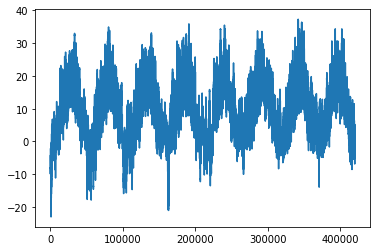

In [16]:
from matplotlib import pyplot as plt
plt.plot(temperature)

In [17]:
6*24

144

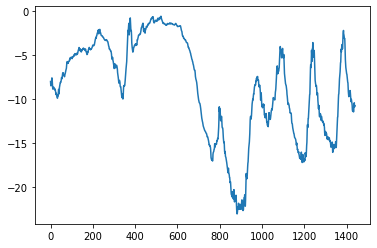

In [18]:
plt.plot(temperature[:1440])

##calculando numero de amostras

In [19]:
num_train_samples = int(0.5 * len(raw_data))

In [20]:
num_val_samples = int(0.25 * len(raw_data))

In [21]:
num_test_samples=len(raw_data) - num_train_samples - num_val_samples

In [22]:
print(num_train_samples)
print(num_val_samples)
print(num_test_samples)

210225
105112
105114


In [23]:
mean = raw_data[:num_train_samples].mean(axis=0)

In [24]:
mean

array([ 988.74929466,    8.82590329,  282.9050718 ,    4.31331863,
         75.87275476,   13.14569946,    9.19414209,    3.95148184,
          5.81050741,    9.30208943, 1218.45204015,    2.14977462,
          3.56048029,  176.4405232 ])

In [25]:
raw_data = raw_data-mean

In [26]:
raw_data[0]

array([  7.77070534, -16.84590329, -17.5050718 , -13.21331863,
        17.42724524,  -9.81569946,  -6.08414209,  -3.73148184,
        -3.87050741,  -6.18208943,  89.29795985,  -1.11977462,
        -1.81048029, -24.1405232 ])

In [27]:
std = raw_data[:num_train_samples].std(axis=0)

In [28]:
raw_data/=std

In [29]:
raw_data[0]

array([ 0.91365151, -1.92064015, -1.97449272, -1.86625827,  1.04801712,
       -1.29131928, -1.46715535, -0.78234525, -1.47012583, -1.4720352 ,
        2.12415558, -0.73016651, -0.77935289, -0.28119316])

In [30]:
from tensorflow import keras

sampling_rate = 6
sequence_length = 120 # 24*5
delay = sampling_rate * (sequence_length + 24 -1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)


In [39]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [41]:
for samples, targets in train_dataset:
  print(samples.shape)
  print(targets.shape)
  break

(256, 120, 14)
(256,)


## Rede Neural Densa

In [42]:
from tensorflow import keras

input=keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x=keras.layers.Flatten()(input)
x=keras.layers.Dense(16, activation='relu')(x)
output = keras.layers.Dense(1)(x)
model = keras.Model(input, output)



In [43]:
callbacks=[
   keras.callbacks.ModelCheckpoint("jean_dense.keras", save_best_only=True)
]

In [44]:
model.compile(
    optimizer="rmsprop",
    loss="mse", # mean squared error
    metrics=["mae"]
)

In [46]:
historico = model.fit(train_dataset,
                      epochs=10,
                      validation_data=val_dataset,
                      callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 55s 67ms/step - loss: 11.6588 - mae: 2.6564 - val_loss: 12.4909 - val_mae: 2.7956
Epoch 2/10
819/819 [==============================] - 57s 69ms/step - loss: 8.7718 - mae: 2.3295 - val_loss: 13.2168 - val_mae: 2.8576
Epoch 3/10
819/819 [==============================] - 57s 69ms/step - loss: 8.1041 - mae: 2.2420 - val_loss: 11.2949 - val_mae: 2.6499
Epoch 4/10
819/819 [==============================] - 53s 64ms/step - loss: 7.6719 - mae: 2.1799 - val_loss: 11.3086 - val_mae: 2.6581
Epoch 5/10
819/819 [==============================] - 53s 64ms/step - loss: 7.4038 - mae: 2.1452 - val_loss: 11.5322 - val_mae: 2.6729
Epoch 6/10
819/819 [==============================] - 53s 65ms/step - loss: 7.1700 - mae: 2.1092 - val_loss: 11.8538 - val_mae: 2.7298
Epoch 7/10
819/819 [==============================] - 53s 64ms/step - loss: 6.9783 - mae: 2.0819 - val_loss: 11.7224 - val_mae: 2.7038
Epoch 8/10
819/819 [==============================] - 

In [47]:
model = keras.models.load_model("/content/jean_dense.keras")

In [50]:
print(model.evaluate(test_dataset)[1])

405/405 [==============================] - 18s 42ms/step - loss: 11.2949 - mae: 2.6499
2.649888038635254


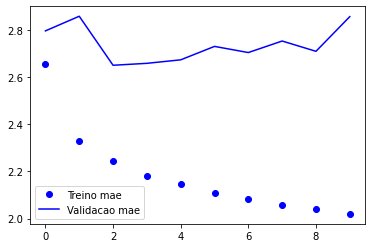

In [52]:
import matplotlib.pyplot as plt

loss= historico.history["mae"]
val_loss=historico.history["val_mae"]
plt.plot(loss, "bo",label="Treino mae")
plt.plot(val_loss, "b",label="Validacao mae")
plt.legend()


## Rede Neural Recorrente

In [54]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.LSTM(16)(inputs)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs,outputs)

callbacks=[
  keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True) 
]

model.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
)

historico = model.fit(train_dataset,
                      epochs=10,
                      validation_data=val_dataset,
                      callbacks=callbacks)



Epoch 1/10
819/819 [==============================] - 104s 124ms/step - loss: 42.5791 - mae: 4.7457 - val_loss: 13.2625 - val_mae: 2.7682
Epoch 2/10
819/819 [==============================] - 99s 120ms/step - loss: 11.2228 - mae: 2.6033 - val_loss: 9.7781 - val_mae: 2.4370
Epoch 3/10
819/819 [==============================] - 99s 120ms/step - loss: 9.8453 - mae: 2.4414 - val_loss: 9.3697 - val_mae: 2.3789
Epoch 4/10
819/819 [==============================] - 100s 121ms/step - loss: 9.3065 - mae: 2.3739 - val_loss: 9.5735 - val_mae: 2.4094
Epoch 5/10
819/819 [==============================] - 99s 120ms/step - loss: 8.8627 - mae: 2.3180 - val_loss: 9.6285 - val_mae: 2.4168
Epoch 6/10
819/819 [==============================] - 101s 123ms/step - loss: 8.5061 - mae: 2.2742 - val_loss: 9.6030 - val_mae: 2.4204
Epoch 7/10
819/819 [==============================] - 98s 120ms/step - loss: 8.2351 - mae: 2.2385 - val_loss: 9.8932 - val_mae: 2.4624
Epoch 8/10
819/819 [=============================

In [56]:
model= keras.models.load_model("jena_lstm.keras")
print(model.evaluate(test_dataset)[1])

405/405 [==============================] - 24s 58ms/step - loss: 10.7767 - mae: 2.5615
2.561511516571045


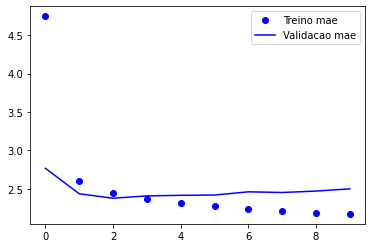

In [57]:
loss= historico.history["mae"]
val_loss=historico.history["val_mae"]
plt.plot(loss, "bo",label="Treino mae")
plt.plot(val_loss, "b",label="Validacao mae")
plt.legend()

##Dropout com RNN

In [35]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = keras.layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs,outputs)

callbacks=[
  keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True) 
]

model.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
)

historico = model.fit(train_dataset,
                      epochs=10,
                      validation_data=val_dataset,
                      callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 425s 428ms/step - loss: 28.4765 - mae: 3.9329 - val_loss: 9.9676 - val_mae: 2.4469
Epoch 2/10
819/819 [==============================] - 348s 425ms/step - loss: 14.8016 - mae: 2.9859 - val_loss: 9.3803 - val_mae: 2.3745
Epoch 3/10
819/819 [==============================] - 344s 419ms/step - loss: 13.9298 - mae: 2.8915 - val_loss: 9.5079 - val_mae: 2.3924
Epoch 4/10
819/819 [==============================] - 346s 423ms/step - loss: 13.3513 - mae: 2.8306 - val_loss: 9.3707 - val_mae: 2.3760
Epoch 5/10
819/819 [==============================] - 347s 423ms/step - loss: 12.8786 - mae: 2.7794 - val_loss: 9.6252 - val_mae: 2.4085
Epoch 6/10
819/819 [==============================] - 344s 420ms/step - loss: 12.4645 - mae: 2.7367 - val_loss: 9.3097 - val_mae: 2.3678
Epoch 7/10
819/819 [==============================] - 343s 418ms/step - loss: 12.1232 - mae: 2.6997 - val_loss: 9.5338 - val_mae: 2.3989
Epoch 8/10
819/819 [=====================

In [36]:
model= keras.models.load_model("jena_lstm_dropout.keras")
print(model.evaluate(test_dataset)[1])

405/405 [==============================] - 26s 63ms/step - loss: 10.7572 - mae: 2.5855
2.585517644882202


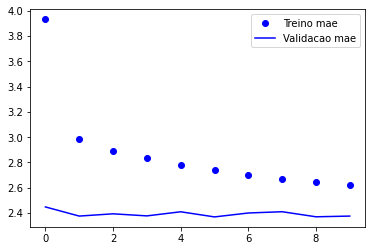

In [37]:
loss= historico.history["mae"]
val_loss=historico.history["val_mae"]
plt.plot(loss, "bo",label="Treino mae")
plt.plot(val_loss, "b",label="Validacao mae")
plt.legend()